# Time series forecasting with FEDOT. Guide

Time series forecasting is a complex task. First of all, because despite the fact that time series forecasting models can give high results, but often require a researcher with high qualifications to adjust the hyperparameters.

But things get easier if you use FEDOT. Let's look at how values in time series can be predicted.

In [2]:
# Additional imports are required
import os 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_absolute_error

# Prerocessing for FEDOT
from fedot.core.models.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.composer.node import PrimaryNode, SecondaryNode
from fedot.core.composer.ts_chain import TsForecastingChain

Let's take a closer look at what we imported from the FEDOT framework. The framework's functionality for time series forecasting is based on autoregressive models. We will use them below. The main meaning of such models can be shown in this picture (fig. 1)

![Fig_1_autoregressive_models.png](https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/Fig_1_autoregressive_models.png) 
Figure 1. Autoregressive models for time series forecasting

But these models are not used directly in the framework. They are placed in containers called "nodes".

## Node
A node is where the model is placed.

In one such node, as in a container, we can put one model, which we want (the list of models will be presented below).

##### You can do it using a simple action:
    node_first = PrimaryNode('trend_data_model')
    
There are two types of nodes: 
* PrimaryNode - node where predictors are the source data;
* SecondaryNode - the node in which the predictors, prediction of the other nodes.

Schematically, it looks like this (Fig. 2).

![fig_2_nodes.png](https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/fig_2_nodes.png) 
Figure 2. Differences between PrimaryNode and SecondaryNode

## Chain
But using only single models is too easy. FEDOT can do much more. We can combine the nodes into chains - let's use Chain class.

Thus, if the model is wrapped in a node, the nodes are wrapped in chain. Below we will look in detail at how you can build such chains and what forecasts they can make.

![fig_3_chains.png](https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/fig_3_chains.png) 
Figure 3. Two examples of constructed chains

## Load example data

Let's load the sea level data and try to predict the 250 next values.

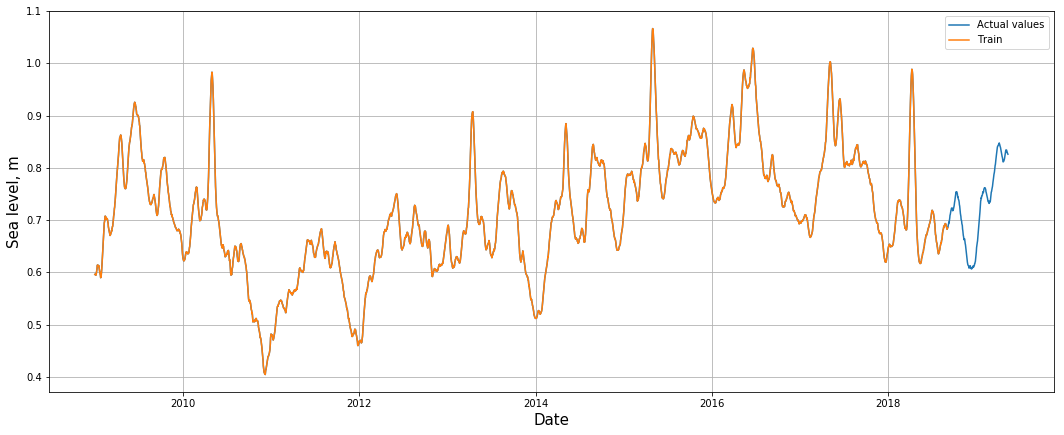

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7
df = pd.read_csv('Sea_level.csv')
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'], df['Actual_level'], label = 'Actual values')
plt.plot(df['Date'], df['Train_level'], label = 'Train')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend()
plt.grid()
plt.show()

## Data preparation

Let's prepare a one-dimensional numpy array for forecasting

In [86]:
# Convert to numpy array your data
arr = np.array(df['Train_level'])
true_values = np.array(df['Actual_level'])

# Last 250 values in our array is nan
forecast_ids = np.ravel(np.argwhere(np.isnan(arr)))
len_forecast = len(forecast_ids)

# We will use only time series without nans
train_array = arr[:forecast_ids[0]]

FEDOT is a multi-functional framework that allows you to solve classification, regression, and clustering problems. Moreover, with FEDOT, you can use specific methods, such as time series forecasting. But to do this we need to get acquainted with two more entities:
* Task - the task that the chain will solve;
* InputData - data that is used for training and prediction.

Thus, to solve the problem, we must choose a model (or several models), put them in chain, define the Task as a time series forecasting, and put the input data in the InputData wrapper.

> Why do we need so much preparations?

The "chain" is a universal tool. In order for this universal tool to work well on a specific task, we have prepared a structure that helps the chain work effectively on a single task - we called it "Task". Here we will focus on the problem of time series forecasting - TaskTypesEnum.ts_forecasting.

FEDOT also has specific data preprocessing, so the data that is submitted to the input must be presented in a single format - "InputData".

In [87]:
# Here we define which task should we use, here we also define two main 
# hyperparameters: forecast_length and max_window_size
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast,
                                max_window_size=30,
                                return_all_steps=False,
                                make_future_prediction=True))

# Prepare data to train the model
train_data = InputData(idx=np.arange(0, len(train_array)),
                       features=None,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Make a "blank", here we need just help FEDOT understand that the 
# forecast should be made exactly the "len_forecast" length
predict_data = InputData(idx=np.arange(0, len_forecast),
                         features=None,
                         target=None,
                         task=task,
                         data_type=DataTypesEnum.ts)

## Single model

Now we can choose such models as (below is not the entire list):
* linear
* lasso
* ridge
* dtreg
* treg
* rfr    
* knnreg

In [88]:
# Prepare chain
single_model = TsForecastingChain(PrimaryNode('knnreg'))

# Fit it
single_model.fit_from_scratch(train_data)

# Predict
predicted_values = single_model.forecast(initial_data=train_data,
                                         supplementary_data=predict_data).predict

Fit chain from scratch


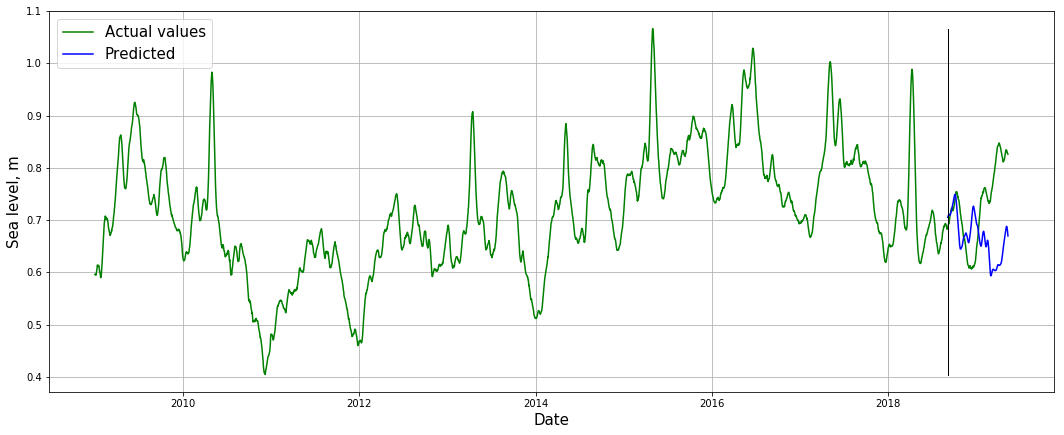

Mean absolute error: 0.09240256


In [89]:
# Replace np.nan with the predicted values
arr[forecast_ids] = predicted_values

plt.plot(df['Date'], df['Actual_level'], label = 'Actual values', c = 'green')
plt.plot(df['Date'][forecast_ids], predicted_values, label = 'Predicted', c = 'blue')
# Plot black line which divide our array into train and test
plt.plot([df['Date'][forecast_ids[0]], df['Date'][forecast_ids[0]]],
         [min(df['Actual_level']), max(df['Actual_level'])], c = 'black', linewidth = 1)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(true_values[forecast_ids], predicted_values)}')

Well, not so bad, let's now replace the window size and choose a different model. At the same time, let's look at what the whole process of building a model looks like.

Fit chain from scratch


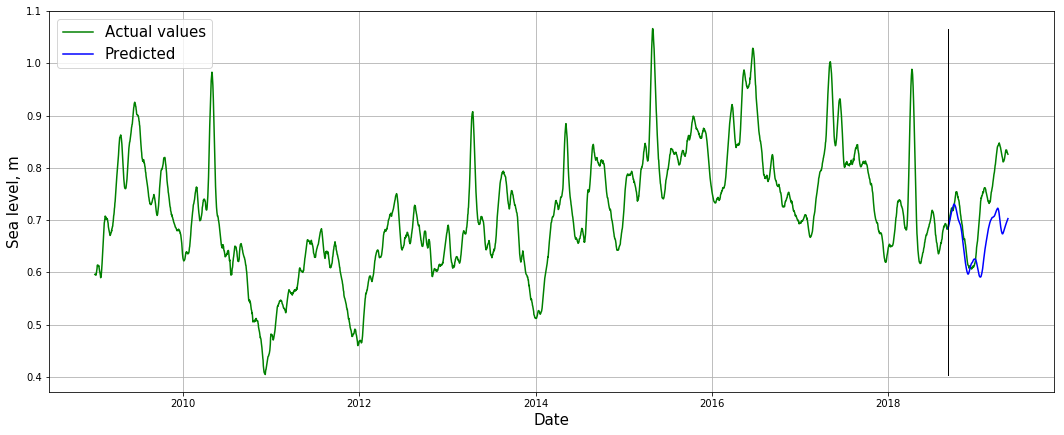

Mean absolute error: 0.06318186381604735


In [85]:
# Here we define 400 elements window size
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast,
                                max_window_size=400,
                                return_all_steps=False,
                                make_future_prediction=True))

# Prepare data to train the model
train_data = InputData(idx=np.arange(0, len(train_array)),
                       features=None,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Make a "blank" for prediction
predict_data = InputData(idx=np.arange(0, len_forecast),
                         features=None,
                         target=None,
                         task=task,
                         data_type=DataTypesEnum.ts)

# Prepare chain - ridge regression
single_model = TsForecastingChain(PrimaryNode('ridge'))

# Fit it
single_model.fit_from_scratch(train_data)

# Predict
predicted_values = single_model.forecast(initial_data=train_data,
                                         supplementary_data=predict_data).predict


# Replace np.nan with the predicted values
arr[forecast_ids] = predicted_values

plt.plot(df['Date'], df['Actual_level'], label = 'Actual values', c = 'green')
plt.plot(df['Date'][forecast_ids], predicted_values, label = 'Predicted', c = 'blue')
# Plot black line which divide our array into train and test
plt.plot([df['Date'][forecast_ids[0]], df['Date'][forecast_ids[0]]],
         [min(df['Actual_level']), max(df['Actual_level'])], c = 'black', linewidth = 1)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(true_values[forecast_ids], predicted_values)}')

#### Much better, but FEDOT can do more! 

## Chain with models

Running the preprocessing and task preparation code below is no different. The important difference here is only in the definition of the chain.

In [120]:
# Define PrimaryNode models - its first level models
node_first = PrimaryNode('trend_data_model')
node_second = PrimaryNode('residual_data_model')

# Define SecondaryNode models - its second level models
node_trend_model = SecondaryNode('ridge', nodes_from=[node_first])
node_residual_model = SecondaryNode('ridge', nodes_from=[node_second])

# Root node - make final prediction
node_final = SecondaryNode('svr', nodes_from=[node_trend_model,
                                              node_residual_model])
chain = TsForecastingChain(node_final)

Using the nodes_from argument, you can determine from which nodes the selected node will receive predictions.

Fit chain from scratch


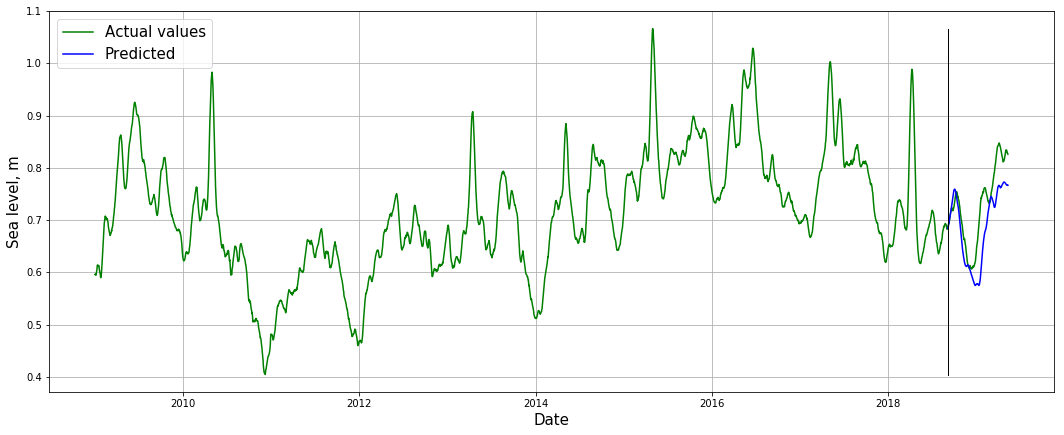

Mean absolute error: 0.04514021936007262


In [121]:
# Here we define 900 elements window size - 
# The larger the model, the larger the window
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast,
                                max_window_size=900,
                                return_all_steps=False,
                                make_future_prediction=True))

# Prepare data to train the model
train_data = InputData(idx=np.arange(0, len(train_array)),
                       features=None,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Make a "blank" for prediction
predict_data = InputData(idx=np.arange(0, len_forecast),
                         features=None,
                         target=None,
                         task=task,
                         data_type=DataTypesEnum.ts)

# Fit the chain
chain.fit_from_scratch(train_data)

# Predict
predicted_values = chain.forecast(initial_data=train_data,
                                  supplementary_data=predict_data).predict


# Replace np.nan with the predicted values
arr[forecast_ids] = predicted_values

plt.plot(df['Date'], df['Actual_level'], label = 'Actual values', c = 'green')
plt.plot(df['Date'][forecast_ids], predicted_values, label = 'Predicted', c = 'blue')
# Plot black line which divide our array into train and test
plt.plot([df['Date'][forecast_ids[0]], df['Date'][forecast_ids[0]]],
         [min(df['Actual_level']), max(df['Actual_level'])], c = 'black', linewidth = 1)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(true_values[forecast_ids], predicted_values)}')

Thus, you can build chains of any configuration and complexity. Good luck!